In [939]:
import os
from dotenv import load_dotenv
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [940]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [941]:
# load the data
df_locations = pd.read_csv('./locations.csv')

# Locations

In [942]:
df_locations.head()

,place_id,name,avg_rating,lat,lng,user_ratings_total,reviews
0,ChIJ1e5UJJF0j1QR6VpPNf8TYiQ,Royal BC Museum,4.6,48.419811,-123.367450,8658,Great museum has very nice and extensive exhib...
1,ChIJmXc0Z6J0j1QR4CJUS73dyZk,Fisherman's Wharf Park,4.5,48.421950,-123.383014,7518,A popular tourist attraction on the Victoria w...
2,ChIJ13vUgIp0j1QRbx3mZXLZILI,Craigdarroch Castle,4.5,48.422629,-123.343723,4836,"This is a neat, old castle that was built well..."
3,ChIJa4uQ3-p0j1QRDtSaFQ5NHrQ,Beacon Hill Park,4.7,48.412222,-123.362778,8431,This is a beautiful and well thought-out park....
4,ChIJS9YYcJB0j1QRPWHIFtwTr18,Victoria Bug Zoo,4.5,48.423300,-123.366668,1821,My daughter and I had a fantastic time at the ...


In [943]:
# look at missing values as a total and a percentage
df_locations.isnull().sum()

place_id               0
name                   0
avg_rating             0
lat                    0
lng                    0
user_ratings_total     0
reviews               15
dtype: int64

In [944]:
# drop the rows with missing values in reviews
df_locations.dropna(subset=['reviews'], inplace=True)

In [945]:
# drop rows where the user_ratings_total is < 5
df_locations = df_locations[df_locations['user_ratings_total'] >= 5]

In [946]:
df_locations.shape

(187, 7)

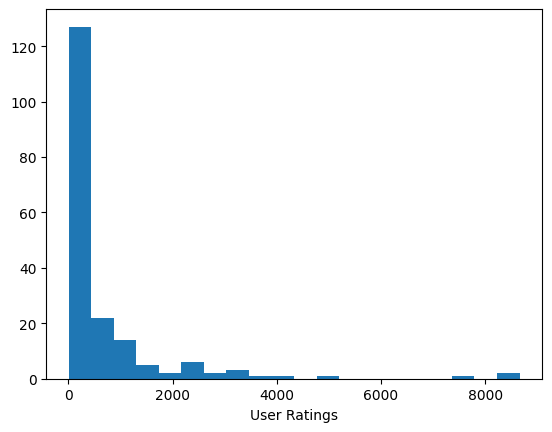

In [947]:
# look at the distribution of user_ratings_total
plt.hist(df_locations['user_ratings_total'], bins=20)
# add an x-axis label
plt.xlabel('User Ratings')
plt.show()

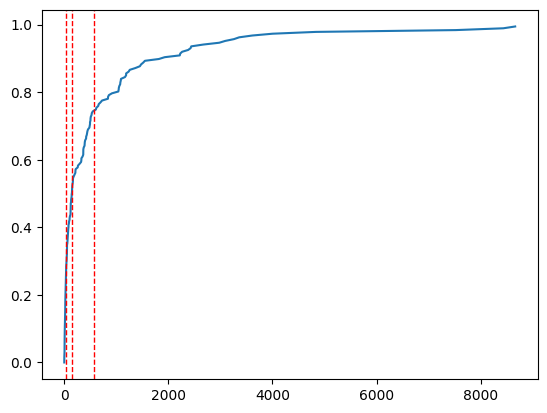

In [948]:
# plot the CDF of user_ratings_total as a line
plt.plot(np.sort(df_locations['user_ratings_total']), np.linspace(0, 1, len(df_locations), endpoint=False))
# plot the quartiles as red dashed lines
plt.axvline(df_locations['user_ratings_total'].quantile(0.25), color='red', linestyle='dashed', linewidth=1)
plt.axvline(df_locations['user_ratings_total'].quantile(0.5), color='red', linestyle='dashed', linewidth=1)
plt.axvline(df_locations['user_ratings_total'].quantile(0.75), color='red', linestyle='dashed', linewidth=1)
plt.show()

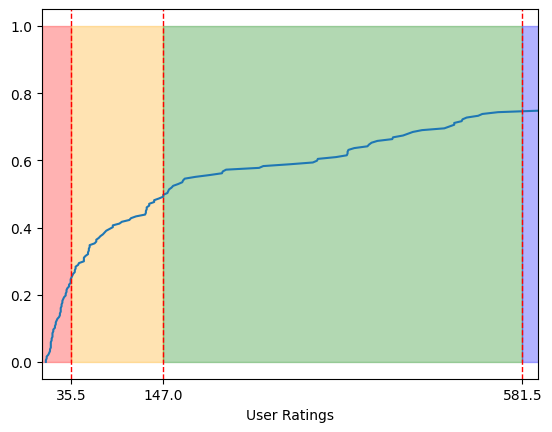

In [949]:
# plot the CDF of user_ratings_total as a line zoomed into 0-1000
plt.plot(np.sort(df_locations['user_ratings_total']), np.linspace(0, 1, len(df_locations), endpoint=False))
plt.xlim(0, 600)
# plot the quartiles as red dashed lines with a label for each quartile
plt.axvline(df_locations['user_ratings_total'].quantile(0.25), color='red', linestyle='dashed', linewidth=1, label='Q1')
plt.axvline(df_locations['user_ratings_total'].quantile(0.5), color='red', linestyle='dashed', linewidth=1, label='Q2')
plt.axvline(df_locations['user_ratings_total'].quantile(0.75), color='red', linestyle='dashed', linewidth=1, label='Q3')

# adding fill

# fill between 0 and Q1
plt.fill_between([0, df_locations['user_ratings_total'].quantile(0.25)], 0, 1, alpha=0.3, color='red')

# fill between Q1 and Q2
plt.fill_between([df_locations['user_ratings_total'].quantile(0.25), df_locations['user_ratings_total'].quantile(0.5)], 0, 1, alpha=0.3, color='orange')

# fill between Q2 and Q3
plt.fill_between([df_locations['user_ratings_total'].quantile(0.5), df_locations['user_ratings_total'].quantile(0.75)], 0, 1, alpha=0.3, color='green')

# fill between Q3 and max
plt.fill_between([df_locations['user_ratings_total'].quantile(0.75), df_locations['user_ratings_total'].max()], 0, 1, alpha=0.3, color='blue')

# add the numerical values of the quartiles on the x-axis
Q1 = df_locations['user_ratings_total'].quantile(0.25)
Q2 = df_locations['user_ratings_total'].quantile(0.5)
Q3 = df_locations['user_ratings_total'].quantile(0.75)

plt.xticks([Q1, Q2, Q3], [Q1, Q2, Q3])

plt.xlabel('User Ratings')
plt.show()

## Feature Engineering

Originally we were going to scale the cosine similarity of the user's input by the average user rating, but after seeing the distribution of the number of reviews we had to come up with a feature which also took into account how many user reveiws there were to achieve that average rating.

https://www.johndcook.com/blog/2011/09/27/bayesian-amazon/

![Probability Liking](./probabilitiy_liking.png)

### Q: Which reseller is likely to give the best service?

*Thanks to this video by 3blue1brown*

https://www.youtube.com/watch?v=8idr1WZ1A7Q

#### A: Pretend that there are two more reviews, one positive and one negative, for each reseller. The resulting ratio is your probability of having a good experience with that reseller.

<img src="./prob_liking_graphic.png" width="400"/>

Using this information we can create a feature for each location as the probability of having a good experience.

### Building the "probability of enjoying" feature


In [950]:
# create a new column in the df_locations dataframe called prob_enjoy
for index, row in df_locations.iterrows():
    positive_percentage = row['avg_rating'] / 5
    
    num_positive_reviews = row['user_ratings_total'] * positive_percentage
    df_locations.loc[index, 'prob_enjoy'] = (num_positive_reviews + 1) / (row['user_ratings_total'] + 1)

In [951]:
# sort according to prob_enjoy
df_locations[["name", "avg_rating", "user_ratings_total", "prob_enjoy"]].sort_values(by=['prob_enjoy'], ascending=False, inplace=False).head(10)

,name,avg_rating,user_ratings_total,prob_enjoy
96,Finlayson Point Beach,5.0,11,1.000000
31,Rainforest Tours,5.0,10,1.000000
135,Bagheera Boutique,5.0,9,1.000000
63,Old Victoria Customs House,5.0,6,1.000000
57,view of Victoria Harbour,5.0,6,1.000000
144,The Standout,5.0,5,1.000000
53,The Breakwater,5.0,8,1.000000
64,Ross Bay Villa,4.9,10,0.981818
41,Gate of Harmonious Interest,4.9,14,0.981333
125,Just For You Fashions Ltd,4.9,16,0.981176


## Building the Model

In [952]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Compute TF-IDF values
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_locations['reviews'])

# Create a DataFrame with these features
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

df_tfidf.head()

,00,10,100,10am,10pm,11,11am,11pm,12,14,...,yukon,yummy,yyj,zara,zero,zesty,zip,zipline,zoo,zoom
0,0.069725,0.0,0.0,0.0,0.092977,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.06095,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075092,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256834,0.0


## Creating the Recommendation Function

In [953]:
# Find the cosine similarity between the user_input and all of the reviews
from sklearn.metrics.pairwise import cosine_similarity

def make_recomendation(user_input, T):
    # Compute TF-IDF values
    user_input_prepared = vectorizer.transform([user_input])
    # Find the cosine similarity between the user_input and all of the reviews
    cosine_similarities = cosine_similarity(user_input_prepared, tfidf_matrix).flatten()
    # scale the cosine_similarities by the prob_enjoy column
    cosine_similarities = cosine_similarities * df_locations['prob_enjoy']**T
    # Find the index of the top 5 most similar locations
    related_locations_indices = cosine_similarities.argsort()[:-6:-1]
    # Print the top 5 most similar locations
    return df_locations.iloc[related_locations_indices]


## Creating a Recommendation

In [957]:
user_input = "I love going to a beach or a park at sunset and then walking through the city at night. I also love to go to museums and learn about the history of the place I'm visiting. My favourite food is sushi and I love to try new restaurants."

In [958]:
recommended = make_recomendation(user_input, 2)

In [959]:
from textwrap import wrap
# print the reviews in the recommended DataFrame but in a way that the text fits in the notebook cell output
for index, row in recommended.iterrows():
    print(row['name'] + ': ' + str(row['avg_rating']))
    print("------------------")
    print('\n'.join(wrap(row['reviews'], 100)))
    print('\n')

Royal BC Museum: 4.6
------------------
Great museum has very nice and extensive exhibits. I went there when they had the wildlife photo-
journalism exhibit which was a interesting one. It wasn’t busy whatsoever but I did go on a rainy
Sunday around 3:00. Would definitely recommend going. It also seems like there was a third floor
exhibit but for some reason it’s closed and I don’t know why. Maybe it will be open sometime in the
future.The Grand Dame of Museums in Victoria, BC.  In the heart of the city; next to the Iconic
Empress Hotel and across from the Famed Victoria Harbour. The displays in the different themed
exhibits are awesome! The extensive information and detail in the displays is fabulous. Plan on
spending a minimum of three hours; more, if your a history buff!This is one of the best museums we
have visited. It has natural history, art, First People cultural history, and an interactive
town/ship/ mine from British colonial history. Really great. Two weeks ago,  that sectio